# Basic Usage

## Climate indicator computations

`xclim` is a library of climate indicators that operate on [xarray](https://docs.xarray.dev/en/stable/) `DataArray` objects.

`xclim` provides two layers of computations, one responsible for computations and units handling (the computation layer, the **indices**), and the other responsible for input health checks and metadata formatting (the CF layer, referring to the Climate and Forecast convention, the **indicators**). Functions from the computation layer are found in `xclim.indices`, while indicator objects from the CF layer are found in *realm* modules (`xclim.atmos`, `xclim.land` and `xclim.seaIce`). Users should always use the indicators, and maybe revert to indices as a last resort if the indicator machinery becomes too heavy for their special edge case.

To use xclim in a project, import both `xclim` and `xarray`.

In [1]:
from __future__ import annotations

import xarray as xr

import xclim
from xclim import testing

Indice calculations are performed by opening a NetCDF-like file, accessing the variable of interest, and calling the indice function, which returns a new `xarray.DataArray`.

For this example, we'll first open a demonstration dataset storing surface air temperature and compute the number of growing degree days (the sum of degrees above a certain threshold) at the monthly frequency.

In [2]:
# Normally, we would use xarray to open a dataset, e.g.:
# ds = xr.open_dataset("your_file.nc")

# For this example, let's use a test dataset from xclim:
ds = testing.open_dataset("ERA5/daily_surface_cancities_1990-1993.nc")
ds.tas

/Users/jullav1/Documents/development/xclim/xclim/testing/utils.py:210: UserWarning: MD5 checksum for /Users/jullav1/.xclim_testing_data/main/ERA5/daily_surface_cancities_1990-1993.nc does not match upstream md5. Attempting new download.
  warnings.warn(msg)


<xarray.DataArray 'tas' (location: 5, time: 1461)>
array([[277.55566, 270.5756 , 273.53882, ..., 259.51328, 267.92664, 264.36823],
       [272.40604, 267.96622, 273.4945 , ..., 249.8702 , 258.33542, 260.20886],
       [245.20546, 252.5626 , 248.2663 , ..., 235.05373, 236.19106, 242.75523],
       [270.6233 , 263.59482, 257.28265, ..., 257.51257, 269.3636 , 261.21143],
       [279.84915, 278.3199 , 279.3029 , ..., 280.15323, 280.74222, 280.94418]],
      dtype=float32)
Coordinates:
    lon       (location) float32 ...
  * location  (location) object 'Halifax' 'Montréal' ... 'Saskatoon' 'Victoria'
    lat       (location) float32 ...
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1993-12-31
Attributes:
    cell_methods:       time: mean within days
    long_name:          Mean daily surface temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K

In [3]:
gdd = xclim.atmos.growing_degree_days(tas=ds.tas, thresh="10.0 degC", freq="YS")
gdd

<xarray.DataArray 'growing_degree_days' (location: 5, time: 4)>
array([[7.76921692e+02, 7.03898560e+02, 6.31244263e+02, 6.51882690e+02],
       [1.22686438e+03, 1.35817456e+03, 1.12669324e+03, 1.22071863e+03],
       [6.99319458e+00, 2.39197693e+01, 6.53686523e-01, 1.87173157e+01],
       [9.29841431e+02, 1.00834296e+03, 7.17684204e+02, 6.29096436e+02],
       [5.87043213e+02, 5.02022339e+02, 5.99313477e+02, 5.67815552e+02]],
      dtype=float32)
Coordinates:
    lon       (location) float32 -63.4 -73.4 -68.4 -106.7 -123.2
  * location  (location) object 'Halifax' 'Montréal' ... 'Saskatoon' 'Victoria'
    lat       (location) float32 44.5 45.5 63.75 52.0 48.5
  * time      (time) datetime64[ns] 1990-01-01 1991-01-01 1992-01-01 1993-01-01
Attributes:
    units:          K days
    cell_methods:   time: mean within days time: sum over days
    history:        [2023-03-29 10:07:57] growing_degree_days: GROWING_DEGREE...
    standard_name:  integral_of_air_temperature_excess_wrt_time
    long_name:      Cumulative sum of temperature degrees for mean daily temp...
    description:    Annual growing degree days (mean temperature above 10.0 d...

This computation was made using the `growing_degree_days` **indicator**. The same computation could be made through the **indice**. You can see how the metadata is alot poorer here.

In [4]:
gdd = xclim.indices.growing_degree_days(tas=ds.tas, thresh="10.0 degC", freq="YS")
gdd

<xarray.DataArray 'tas' (location: 5, time: 4)>
array([[7.76921692e+02, 7.03898560e+02, 6.31244263e+02, 6.51882690e+02],
       [1.22686438e+03, 1.35817456e+03, 1.12669324e+03, 1.22071863e+03],
       [6.99319458e+00, 2.39197693e+01, 6.53686523e-01, 1.87173157e+01],
       [9.29841431e+02, 1.00834296e+03, 7.17684204e+02, 6.29096436e+02],
       [5.87043213e+02, 5.02022339e+02, 5.99313477e+02, 5.67815552e+02]],
      dtype=float32)
Coordinates:
    lon       (location) float32 -63.4 -73.4 -68.4 -106.7 -123.2
  * location  (location) object 'Halifax' 'Montréal' ... 'Saskatoon' 'Victoria'
    lat       (location) float32 44.5 45.5 63.75 52.0 48.5
  * time      (time) datetime64[ns] 1990-01-01 1991-01-01 1992-01-01 1993-01-01
Attributes:
    units:    K d

The call to `xclim.indices.growing_degree_days` first checked that the input variable units were units of temperature, ran the computation, then set the output's units to the appropriate unit (here ``"K d"`` or Kelvin days). As you can see, the **Indicator** returned the same output, but with more metadata, it also performed more checks as explained below.

`growing_degree_days` makes most sense with **daily input**, but could theoretically accept other source frequencies. The computational layer (*`Indice`*) assumes that users have checked that the input data has the expected temporal frequency and has no missing values. However, no checks are performed, so the output data could be wrong (which is why it's always safer to use **`Indicator`** objects from the CF layer, as demonstrated in the following section).

Finally, as almost all indices, the function takes a `freq` argument to specify over what time period it is computed. These are called "Offset Aliases" and are the same as the resampling string arguments. Valid arguments are detailed in [pandas docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) (note that aliases involving "business" notions are not supported by `xarray` and thus could raise issues in xclim.

### Units Handling paradigm

Indices are written in order to be flexible as to the sampling frequency and units of the data. You _can_ use `growing_degree_days` on, for example, the 6-hourly data, but the output will then be in degree-hour units (``"K h"``). Moreover, all units, even when untouched by the calculation, will be reformatted into a CF-compliant symbol format. This behaviour was chosen to ensure consistency between all indices.

Very few indices will convert their output to specific units; Rather, it is the dimensionality that will be consistent on output. The [Units Handling](units.ipynb) page goes more into detail on how unit conversion can easily be done.

This doesn't apply to **`Indicators`**. Those will always output data in a specific unit, the one listed in the `Indicators.cf_attrs` metadata dictionary.


##  Indicators

**Indices with Health Checks and Metadata Attributes**

Indicator instances from the CF layer are found in modules bearing the name of the computational realm in which its input variables are typically found: `xclim.atmos`, `xclim.land` and `xclim.seaIce`. These objects run sanity checks on the input variables and set output's metadata according to CF-conventions when applicable. Some checks involve:

* Identifying periods where missing data significantly impacts the calculation and omits calculations for those periods. Those are called "missing methods" and are detailed in section [Health checks](../checks.rst).
* Appending process history and maintaining the historical provenance of file metadata.
* Writing [Climate and Forecast Convention](https://cfconventions.org/) compliant metadata based on the variables and indices calculated.

Those modules are best used for producing NetCDF files that will be shared with users. See [Climate Indicators](../indicators.rst) for a list of available indicators.

If we run the `growing_degree_days` indicator over a non-daily dataset, we'll be warned that the input data is not daily. That is, running ```xclim.atmos.growing_degree_days(ds.air, thresh='10.0 degC', freq='MS')``` will fail with a `ValidationError`:

In [5]:
# Show that data is not at a daily time frequency

ds6h = xr.tutorial.open_dataset("air_temperature")
xr.infer_freq(ds6h.time)

'6H'

In [6]:
gdd = xclim.atmos.growing_degree_days(tas=ds6h.air, thresh="10.0 degC", freq="MS")

ValidationError: Frequency of time series not strictly in ['D']. To mute this, set xclim's option data_validation='log'.

Resampling to a daily frequency and running the same indicator succeeds, but we will still get warnings from the CF metadata checks.

In [7]:
daily_ds = ds6h.resample(time="D").mean(keep_attrs=True)
gdd = xclim.atmos.growing_degree_days(daily_ds.air, thresh="10.0 degC", freq="YS")

/Users/jullav1/Documents/development/xclim/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/jullav1/Documents/development/xclim/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


To suppress the CF validation warnings, we can set xclim to send these warnings to the log instead of raising a warning or an error. We also could set `data_validation='warn'` to be able to run the indicator on non-daily data. These options can be set globally or within a context manager with [set_options](../api.rst#options-submodule).

The missing method which determines if a period should be considered missing or not can be controlled through the `check_missing` option, globally or contextually. The main missing methods also have options that can be modified.

In [8]:
with xclim.set_options(
    check_missing="pct",
    missing_options={"pct": dict(tolerance=0.1)},
    cf_compliance="log",
):
    # Change the missing method to "percent", instead of the default "any"
    # Set the tolerance to 10%, periods with more than 10% of missing data
    #     in the input will be masked in the ouput.
    gdd = xclim.atmos.growing_degree_days(daily_ds.air, thresh="10.0 degC", freq="MS")

Some indicators also expose time-selection arguments as `**indexer` keywords. This allows to run the indice on a subset of the time coordinates, for example only on a specific season, month, or between two dates in every year. It relies on the [select_time](../xclim.core.rst#xclim.core.calendar.select_time) function. Some indicators will simply select the time period and run the calculations, while others will smartly perform the selection at the right time, when the order of operation makes a difference. All will pass the `indexer` kwargs to the missing value handling, ensuring that the missing values _outside_ the valid time period are **not** considered.

The next example computes the annual sum of growing degree days over 10 °C, but only considering days from the 1st of April to the 30th of September.

In [9]:
with xclim.set_options(cf_compliance="log"):
    gdd = xclim.atmos.growing_degree_days(
        tas=daily_ds.air, thresh="10 degC", freq="YS", date_bounds=("04-01", "09-30")
    )
gdd

<xarray.DataArray 'growing_degree_days' (time: 2, lat: 25, lon: 53)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.3140015e+01, 5.0820099e+01, 6.6547607e+01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [2.7736938e+03, 2.6248127e+03, 2.5183259e+03, ...,
         2.6201809e+03, 2.5202236e+03, 2.4362007e+03],
        [2.8073425e+03, 2.7539409e+03, 2.6544858e+03, ...,
         2.6141130e+03, 2.6077131e+03, 2.5585962e+03],
        [2.8185554e+03, 2.8164487e+03, 2.7658499e+03, ...,
         2.6862107e+03, 2.6818704e+03, 2.6931643e+03]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0225220e+00, 5.5400085e+00, 1.0475037e+01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [2.8183235e+03, 2.6905312e+03, 2.6107827e+03, ...,
         2.5506511e+03, 2.4474639e+03, 2.3652024e+03],
        [2.8695332e+03, 2.8242588e+03, 2.7269099e+03, ...,
         2.5259944e+03, 2.5199478e+03, 2.4677590e+03],
        [2.8881079e+03, 2.8856880e+03, 2.8283704e+03, ...,
         2.5869858e+03, 2.5948555e+03, 2.6111182e+03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 2014-01-01
Attributes:
    units:          K days
    cell_methods:    time: sum over days
    history:        [2023-03-29 10:07:59] growing_degree_days: GROWING_DEGREE...
    standard_name:  integral_of_air_temperature_excess_wrt_time
    long_name:      Cumulative sum of temperature degrees for mean daily temp...
    description:    Annual growing degree days (mean temperature above 10 degc).

Finally, xclim also allows to call indicators using datasets and variable names.

In [10]:
with xclim.set_options(cf_compliance="log"):
    gdd = xclim.atmos.growing_degree_days(
        tas="air", thresh="10.0 degC", freq="MS", ds=daily_ds
    )

    # variable names default to xclim names, so we can even do this:
    renamed_daily_ds = daily_ds.rename(air="tas")
    gdd = xclim.atmos.growing_degree_days(
        thresh="10.0 degC", freq="MS", ds=renamed_daily_ds
    )

## Graphics

Xclim does not have specific functions to create graphics. However, it is built to ensure that Indices and Indicators always have appropriate axis-related metadata that libraries like [`Matplotlib`](https://matplotlib.org/) depend on to generate detailed and informative graphics.

This graphical functionality is entirely thanks to `xarray`, so the following examples are applicable to generic `xarray.DataArray` objects. For more examples, see the directions suggested by [xarray's plotting documentation](https://docs.xarray.dev/en/stable/user-guide/plotting.html)

The xarray plot functions creates an histogram when the DataArray has 3 or more dimensions. In previous steps, xclim automatically filled the `long_name` and `units` attributes which xarray uses to label the x-axis.

long_name: Cumulative sum of temperature degrees for mean daily temperature above 10.0 degc
units: K days


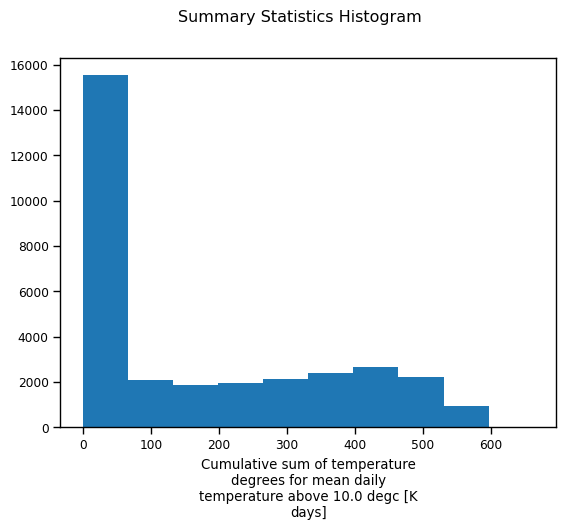

In [20]:
import matplotlib.pyplot as plt

print('long_name:',gdd.attrs['long_name'])
print('units:', gdd.attrs['units'])

gdd.plot()
plt.suptitle("Summary Statistics Histogram")
plt.draw()

When the DataArray only has a `time` dimension, xarray plots a timeseries. In this case, xarray uses the `long_name` and `units` attributes provided by xclim to label the y-axis.

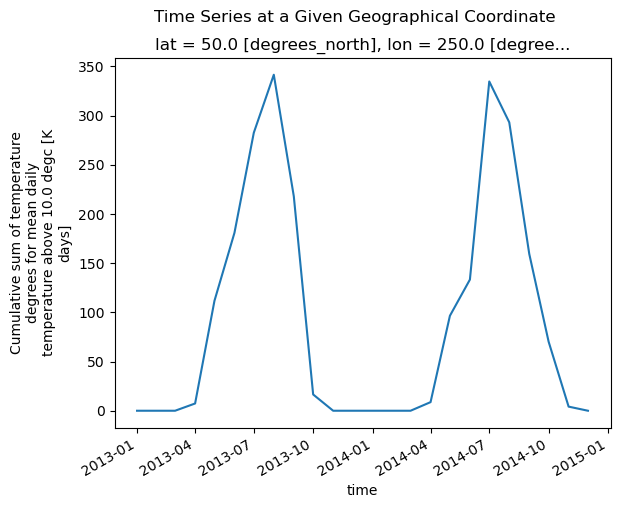

In [12]:
gdd.isel(lon=20, lat=10).plot()
plt.suptitle("Time Series at a Given Geographical Coordinate")
plt.draw()

When the DataArray only has 2 dimensions, xarray plots a heatmap. In this case, xarray uses the `long_name` and `units` attributes provided by xclim to label the colorbar.

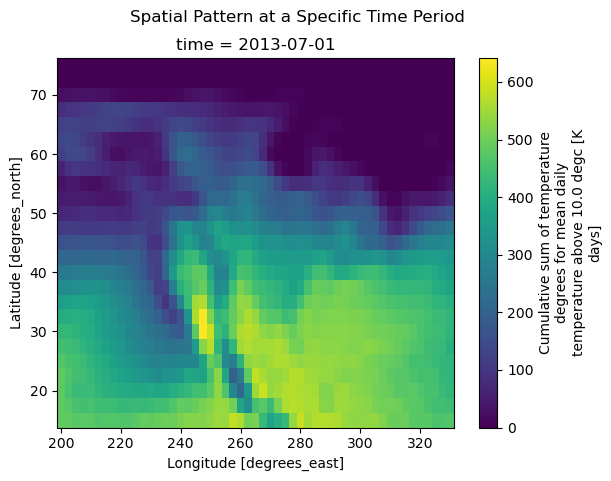

In [13]:
gdd.sel(time="2013-07-01").plot()
plt.suptitle("Spatial Pattern at a Specific Time Period")
plt.draw()


### Writing DataArrays and Datasets to disk

To save the data as a new NetCDF, use `to_netcdf`:

In [ ]:
gdd.to_netcdf("monthly_growing_degree_days_data.nc")

<div class="alert alert-info">

It's possible to save Dataset objects to other file formats. For more information see: [xarray's documentation](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

</div>
